In [1]:
from __future__ import annotations
from typing import Callable, Dict, Tuple, List

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (accuracy_score, roc_auc_score, confusion_matrix, roc_curve, auc)
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, Input, Conv1D, LSTM, BatchNormalization, Bidirectional, GlobalAveragePooling1D, MaxPooling1D, Flatten, Dense, Dropout, Input
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from tensorflow.keras import regularizers
from matplotlib.colors import LinearSegmentedColormap, Normalize
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
import pandas as pd
from tqdm import tqdm
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

2025-05-16 10:07:00.025413: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-16 10:07:25.192006: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


**Training framework for all models**

In [56]:
def get_dense_builder(dropout: float = 0.0,
                      lr: float = 1e-4,
                      l2: float = 1.0) -> Callable[[int, int], Sequential]:

    def _builder(n_features: int, n_classes: int) -> Sequential:
        model = Sequential([
            Input(shape=(n_features,)),
            Dense(n_features//16, activation='relu'),
            Dense(n_features//32, activation='relu'),
            Dense(n_classes, activation='softmax')
        ])
        opt = Adam(learning_rate=lr)
        model.compile(optimizer=opt,
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        return model
    _builder.needs_onehot = True     
    return _builder
    

def get_logreg_builder(**kwargs):
    def _builder(_: int, __: int):
        return LogisticRegression(max_iter=1000,
                                  class_weight='balanced',
                                  n_jobs=-1,
                                  penalty='l2',
                                  **kwargs)
    _builder.needs_onehot = False
    return _builder

def plot_history(history):
    plt.plot(history.history["accuracy"], label="train")
    plt.plot(history.history["val_accuracy"], label="val")
    plt.title(f"Fold {fold} rep {rep+1}/{reps}")
    plt.xlabel("Epochs"); plt.ylabel("Accuracy")
    plt.legend(); plt.show()

    plt.plot(history.history["loss"], label="train")
    plt.plot(history.history["val_loss"], label="val")
    plt.title(f"Fold {fold} rep {rep+1}/{reps}")
    plt.xlabel("Epochs"); plt.ylabel("Loss")
    plt.legend(); plt.show()     

def get_cnnlstm_builder(dropout: float = 0.0,
                        lr: float = 1e-4,
                        l2: float = 0.0) -> Callable[[Tuple[int, int], int], Sequential]:
    

    def _builder(input_shape: Tuple[int, int], n_classes: int) -> Sequential:
        length, n_feat = input_shape
        model = Sequential([
            Input(shape=(length, n_feat)),

            Conv1D(filters=128, kernel_size=5, activation="relu", padding="same"),
            MaxPooling1D(pool_size=2),
            Conv1D(filters=128, kernel_size=5, activation="relu", padding="same"),
            MaxPooling1D(pool_size=2),
            Conv1D(filters=128, kernel_size=5, activation="relu", padding="same"),
            MaxPooling1D(pool_size=2),
            Conv1D(filters=128, kernel_size=5, activation="relu", padding="same"),
            MaxPooling1D(pool_size=2),
            Conv1D(filters=128, kernel_size=5, activation="relu", padding="same"),
            MaxPooling1D(pool_size=2),

            GlobalAveragePooling1D(),

            Dense(64, activation="relu"),
            Dropout(dropout),
            Dense(n_classes, activation="softmax")
        ])
        opt = Adam(learning_rate=lr, weight_decay=l2)
        model.compile(optimizer=opt,
                      loss="categorical_crossentropy",
                      metrics=["accuracy"])
        return model
    
    _builder.needs_onehot = True   
    return _builder

MODEL_REGISTRY: Dict[str, Callable] = {
    "dense":   get_dense_builder(),
    "cnnlstm": get_cnnlstm_builder(),
    "logreg":  get_logreg_builder(),
}

def run_cv(model_key: str,
           X: np.ndarray,
           y: np.ndarray,
           class_names: List[str],
           n_splits: int = 3,
           dense_reps: int = 10,
           random_state: int = 0,
           verbose: bool = True,
           scaler: str = "minmax") -> Tuple[List[dict], List[str]]:
    
    if model_key != "cnnlstm":
        if scaler == "standard":
            X = StandardScaler().fit_transform(X)
        elif scaler == "minmax":
            X = MinMaxScaler().fit_transform(X)
        elif scaler != "minmax" and scaler != "standard":
            raise ValueError(f"Scaler '{scaler}' not supported. "
                            "Use 'standard' or 'minmax'.")

    if X.ndim == 3 and model_key != "cnnlstm":
        print(f"Detected 3‑D input X{X.shape}; using 'cnnlstm' model.")
        model_key = "cnnlstm"

    builder = MODEL_REGISTRY[model_key]
    onehot_needed = getattr(builder, "needs_onehot", False)

    if y.ndim == 1:                      
        y_cls  = y
        y_1hot = (OneHotEncoder(sparse_output=False)
                  .fit_transform(y[:, None]) if onehot_needed else None)
    else:                                 
        y_cls  = np.argmax(y, axis=1)
        y_1hot = y if onehot_needed else None

    skf = StratifiedKFold(n_splits=n_splits,
                          shuffle=True,
                          random_state=random_state)

    fold_histories = []
    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y_cls), 1):
        best_acc, best_model = -np.inf, None

        reps = dense_reps if ((model_key == "dense") or (model_key == "cnnlstm")) else 1
        for rep in range(reps):
            n_classes = (y_1hot.shape[1] if onehot_needed
                         else len(np.unique(y_cls)))

            in_desc = X.shape[1:] if model_key == "cnnlstm" else X.shape[1]
            model = builder(in_desc, n_classes)

            X_train, X_test = X[train_idx], X[test_idx]
            if onehot_needed:
                y_train, y_test = y_1hot[train_idx], y_1hot[test_idx]
            else:
                y_train, y_test = y_cls[train_idx], y_cls[test_idx]

            if model_key == "dense" or model_key == "cnnlstm":   
                early = EarlyStopping("val_loss", patience=25,
                                      restore_best_weights=True)
                history = model.fit(X_train, y_train,
                          validation_data=(X_test, y_test),
                          epochs=10_000, verbose=0, batch_size=8,
                          callbacks=[early]
                          )

                #     plot_history(history)
                
                y_prob = model.predict(X_test, verbose=0)

            else:                                
                model.fit(X_train, y_train)
                if hasattr(model, "predict_proba"):
                    y_prob = model.predict_proba(X_test)

                    if y_prob.ndim == 1:
                        y_prob = np.vstack([1 - y_prob, y_prob]).T
                else: 
                    scores = model.decision_function(X_test)
                    if scores.ndim == 1:     
                        scores = np.vstack([-scores, scores]).T
                    y_prob = _softmax(scores)

            y_pred = np.argmax(y_prob, axis=1)
            acc = accuracy_score(y_cls[test_idx], y_pred)

            auc_score = roc_auc_score(y_cls[test_idx], y_prob[:, 1])

            if verbose:
                print(f"  rep {rep+1}/{reps}: acc={acc:.3f}  auc={auc_score:.3f}")
                
            if acc > best_acc:
                best_acc = acc
                best_model = model
                best_prob  = y_prob
                best_pred  = y_pred

        if best_prob.shape[1] == 2:          
            fpr, tpr, _ = roc_curve(y_cls[test_idx], best_prob[:, 1])
            roc_auc = auc(fpr, tpr)
        else:                         
            fpr = tpr = None
            roc_auc = roc_auc_score(y_cls[test_idx], best_prob,
                                    multi_class='ovr', average='macro')

        cm = confusion_matrix(y_cls[test_idx], best_pred)

        fold_histories.append(dict(model=best_model,
                                   acc=best_acc,
                                   cm=cm,
                                   fpr=fpr, tpr=tpr, auc=roc_auc))
        if verbose:
            print(f"Fold {fold}: acc={best_acc:.3f}  auc={roc_auc:.3f}")
    if verbose:
        print(f"\n===  CV accuracy: {np.mean([h['acc'] for h in fold_histories]):.3f}  ===")
        print(f"===  CV AUC: {np.mean([h['auc'] for h in fold_histories]):.3f}  ===")
    return fold_histories, class_names

def plot_fold_metrics(fold_histories, class_names):
    for i, h in enumerate(fold_histories, 1):
        fpr, tpr, roc_auc = h["fpr"], h["tpr"], h["auc"]
        cm = h["cm"]

        if fpr is not None:  
            plt.figure()
            plt.plot(fpr, tpr, label=f'Fold {i} (AUC={roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], '--', color='gray')
            plt.xlabel("FPR"); plt.ylabel("TPR")
            plt.title(f"ROC – Fold {i}"); plt.legend(); plt.show()

        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names, yticklabels=class_names)
        plt.title(f"Confusion – Fold {i}")
        plt.ylabel("Actual"); plt.xlabel("Predicted")
        plt.tight_layout(); plt.show()


def plot_agg_metrics(fold_histories, class_names):
    cms = np.stack([h["cm"] for h in fold_histories], axis=0)
    avg_cm = cms.sum(axis=0)
    acc = np.trace(avg_cm) / np.sum(avg_cm)
    print(f"\n===  Mean CV accuracy: {acc:.3f}  ===")

    plt.figure(figsize=(6, 5))
    sns.heatmap(avg_cm, annot=True, fmt='.1f', cmap='Purples',
                xticklabels=class_names, yticklabels=class_names)
    plt.title("Average confusion matrix"); plt.ylabel("Actual"); plt.xlabel("Predicted")
    plt.tight_layout(); plt.show()

    if fold_histories[0]["fpr"] is not None:
        plt.figure()
        for i, h in enumerate(fold_histories, 1):
            plt.plot(h["fpr"], h["tpr"], label=f'Fold {i} (AUC={h["auc"]:.2f})')
        plt.plot([0, 1], [0, 1], '--', color='gray')
        plt.xlabel("FPR"); plt.ylabel("TPR")
        plt.title("Combined ROC"); plt.legend(); plt.tight_layout(); plt.show()

def _softmax(z):
    z_exp = np.exp(z - z.max(axis=1, keepdims=True))
    return z_exp / z_exp.sum(axis=1, keepdims=True)

def _raw_importance(model, model_key: str) -> np.ndarray:

    if model_key == "dense":                    
        W = model.layers[-1].get_weights()[0]   
        return np.mean(np.abs(W), axis=1)

    if model_key in {"logreg"}:       
        return np.mean(model.coef_, axis=0)

    raise ValueError(f"No importance rule for model_key='{model_key}'")


def plot_cv_feature_importance(fold_histories: List[dict],
                               feature_names: List[str],
                               model_key: str,
                               top_n: int = 20):

    raw = [_raw_importance(h["model"], model_key) for h in fold_histories]
    imp = np.mean(raw, axis=0) 

    idx = np.argsort(imp)[::-1][:top_n]
    imp_top = imp[idx]
    names_top = [feature_names[i] for i in idx]

    plt.figure(figsize=(6, 0.15*top_n + 1))

    colors = ['#F7D849', '#DFDFDF', '#935EA1']
    colormap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)

    norm = Normalize(vmin=imp_top.min(), vmax=imp_top.max())
    mapped_colors = [colormap(norm(val)) for val in imp_top]

    sns.barplot(x=imp_top, y=names_top, palette=mapped_colors)

    plt.title(f"{model_key.upper()} – mean feature importance (top {max(top_n, len(imp_top))})", fontsize=16)
    plt.xlabel("Importance for 47S class prediction", fontsize=14); plt.ylabel("")
    plt.yticks(fontsize=12)
    sns.despine()
    plt.tight_layout(); 
    plt.savefig(f"/ceph/hpc/home/novljanj/data_storage/projects/nucleolus_enriched_proteins/results/all_training_methods_integration/feature_importance_{model_key}.svg", bbox_inches='tight')
    plt.show()

**Loading of encodings into feature and label matrix (X, y)**

In [5]:
def encode_localcider_dataset(df: pd.DataFrame,
                               feature_cols=None,
                               label_col="Label"):

    if feature_cols is None:
        feature_cols = df.columns[6:]
        
    X = df[feature_cols].to_numpy(dtype=np.float32)
    
    enc = OneHotEncoder(sparse_output=False, dtype=np.float32)
    y = enc.fit_transform(df[[label_col]])

    return X, y

def encode_sequence_padded(
    df: pd.DataFrame,
    seq_col: str = "Sequence",
    label_col: str = "Label"
                            ) -> tuple[np.ndarray, np.ndarray]:
    
    alphabet = "ACDEFGHIKLMNPQRSTVWY"
    unknown_token         = "X"  # slot for anything not in AA_ALPHABET

    if unknown_token and unknown_token not in alphabet:
        alphabet += unknown_token
    char_to_idx = {aa: i for i, aa in enumerate(alphabet)}
    depth = len(alphabet)

    seq_idx_lists = [
        [char_to_idx.get(ch, char_to_idx[unknown_token])
         for ch in seq.upper()]
        for seq in df[seq_col].astype(str)
    ]

    ragged_int = tf.ragged.constant(seq_idx_lists, ragged_rank=1, dtype=tf.int32)
    ragged_oh  = tf.one_hot(ragged_int, depth, dtype=tf.float32)
    X_tensor   = ragged_oh.to_tensor(default_value=0.0)    # shape=(B, max_len, depth)
    X = X_tensor.numpy()

    enc = OneHotEncoder(sparse_output=False, dtype=np.float32)
    y = enc.fit_transform(df[[label_col]])

    return X, y

def prepare_esm2_encodings(esm_2_file_name: str):
    representations_45S_47S_df = pd.read_csv("/ceph/hpc/home/novljanj/data_storage/projects/nucleolus_enriched_proteins/data/for_training/sequence_and_groups_for_esm2_15B_representations.tsv", sep="\t")
    representations_45S_47S = np.load(f'/ceph/hpc/home/novljanj/data_storage/projects/nucleolus_enriched_proteins/results/representations/{esm_2_file_name}.npy')

    group_array = np.array(representations_45S_47S_df['Label'].tolist()).reshape(-1, 1)

    encoder = OneHotEncoder(sparse=False)
    group_onehot = encoder.fit_transform(group_array)
    group_onehot.shape

    y = group_onehot
    X = representations_45S_47S

    return X, y

In [50]:
representations_45S_47S_df = pd.read_csv("/ceph/hpc/home/novljanj/data_storage/projects/nucleolus_enriched_proteins/results/with_calculated_localCider/45S_47S_localcider_features_w_nardini_w_uniprot_V2.tsv", sep="\t")
feature_names = representations_45S_47S_df.columns[6:]

X_cider, y_cider = encode_localcider_dataset(representations_45S_47S_df, feature_names)
X_seqs, y_seqs = encode_sequence_padded(representations_45S_47S_df)

X_esm2, y_esm2 = prepare_esm2_encodings("representations_45S_47S_esm2_650M")

print(X_cider.shape, y_cider.shape)
print(X_seqs.shape, y_seqs.shape)   
print(X_esm2.shape, y_esm2.shape)

(202, 320) (202, 2)
(202, 1970, 21) (202, 2)
(202, 1280) (202, 2)


/ceph/hpc/home/novljanj/.conda/envs/tf/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


**Beam search for the most predictive feature amongst 320 manually encoded**

In [ ]:
def beam_forward_select(X: np.ndarray,
                        y: np.ndarray,
                        class_names: list[str],
                        feature_names: list[str] | None = None,
                        *,
                        model_key: str = "dense",
                        n_splits: int = 3,
                        dense_reps: int = 3,
                        tol: float = 1e-4,
                        max_features: int | None = None,
                        beam_width: int = 5,
                        random_state: int = 0,
                        verbose: bool = True):


    n_feats = X.shape[1]
    if feature_names is None:
        feature_names = [f"f{i}" for i in range(n_feats)]

    beams = [([], -np.inf, [])]
    prev_best_score = -np.inf

    for depth in range(max_features or n_feats):
        all_children = []

        for selected, _, history in beams:
            remaining = [f for f in range(n_feats) if f not in selected]
            cand_scores: list[tuple[float,int]] = []

            for f in remaining:
                fh, _ = run_cv(
                    model_key,
                    X[:, selected + [f]],
                    y,
                    class_names=class_names,
                    n_splits=n_splits,
                    dense_reps=(dense_reps if model_key=="dense" else 1),
                    random_state=random_state,
                    verbose=False
                )
                mean_acc = np.mean([h["auc"] for h in fh])
                cand_scores.append((mean_acc, f))

            cand_scores.sort(reverse=True, key=lambda x: x[0])
            for mean_acc, f in cand_scores[:beam_width]:
                all_children.append((selected + [f], mean_acc, history + [(f, mean_acc)]))

        all_children.sort(reverse=True, key=lambda x: x[1])
        beams = all_children[:beam_width]
        best_score = beams[0][1]

        if verbose:
            scores = [round(b[1],4) for b in beams]
            print(f"\nAfter selecting {depth+1} features, top beams: {scores}")

        if best_score - prev_best_score < tol:
            if verbose:
                gain = best_score - prev_best_score
                print(f"improvement = {gain:.4f} < tol={tol}; stopping.\n")
            break

        prev_best_score = best_score

    named_beams = []
    for sel_idxs, score, history in beams:
        names      = [feature_names[i] for i in sel_idxs]
        hist_named = [(feature_names[i], sc) for i, sc in history]
        named_beams.append((names, score, hist_named))

    if verbose:
        print("Beam selection finished")
        for names, sc, _ in named_beams:
            print(f"  {names}  → auc={sc:.4f}")

    return named_beams

class_names = ["45S", "47S"]

named_beams = beam_forward_select(
    X_cider, y_cider,
    class_names=class_names,
    feature_names=feature_names,
    model_key="logreg",    
    tol=0.001,
    n_splits=3,
    random_state=0,
    beam_width=10,       
)

named_beams

**Loading of final features encodings into feature and label matrix (X, y)**

In [52]:
feature_names =   ['count_negative', 'fraction_positive', 'zsc_HYDROPHOBIC_NEGATIVE', 'RRM', 'frac_I', 'length', 'frac_F', 'Helicase C-terminal', 'zsc_HYDROPHOBIC_ALANINE', 'Basic residues', 'zsc_NEGATIVE_ALANINE', 'EF-hand', 'zsc_POLAR_NEGATIVE', 'SGS']
X_cider, y_cider = encode_localcider_dataset(representations_45S_47S_df, feature_names)
print(X_cider.shape, y_cider.shape)

(202, 14) (202, 2)


**Final training for logistic regression model on selected features**

  rep 1/1: acc=0.809  auc=0.816
Fold 1: acc=0.809  auc=0.816
  rep 1/1: acc=0.821  auc=0.895
Fold 2: acc=0.821  auc=0.895
  rep 1/1: acc=0.821  auc=0.876
Fold 3: acc=0.821  auc=0.876

===  CV accuracy: 0.817  ===
===  CV AUC: 0.862  ===

===  Mean CV accuracy: 0.817  ===


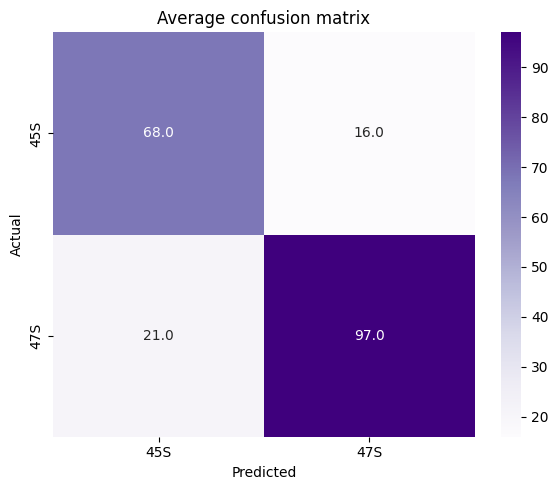

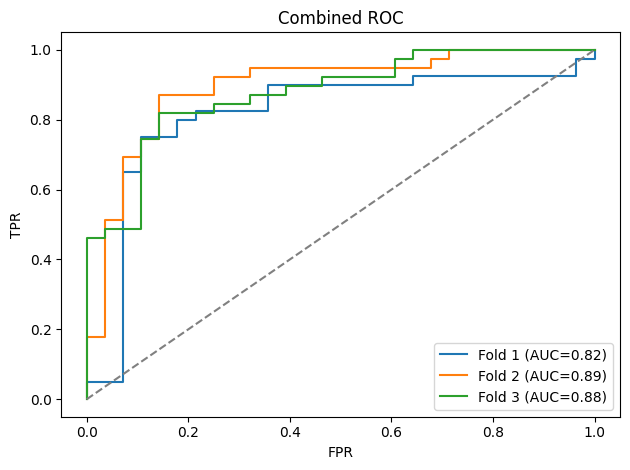

/tmp/ipykernel_190986/3363033832.py:279: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=imp_top, y=names_top, palette=mapped_colors)


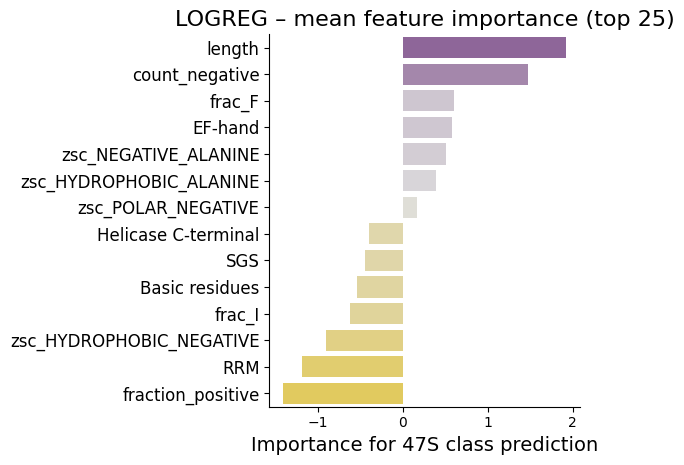

In [105]:
class_names = ["45S", "47S"]
model_key = "logreg"

fold_hist_cider, cls_cider = run_cv(model_key, X_cider, y_cider, class_names, verbose=True, random_state=0, n_splits=3)

plot_agg_metrics(fold_hist_cider, class_names)
plot_cv_feature_importance(fold_hist_cider, feature_names, model_key=model_key, top_n=25)

**Final training for esm2 representation model**

  rep 1/10: acc=0.765  auc=0.820
  rep 2/10: acc=0.706  auc=0.812
  rep 3/10: acc=0.750  auc=0.837
  rep 4/10: acc=0.765  auc=0.847
  rep 5/10: acc=0.721  auc=0.800
  rep 6/10: acc=0.750  auc=0.780
  rep 7/10: acc=0.735  auc=0.794
  rep 8/10: acc=0.706  auc=0.798
  rep 9/10: acc=0.765  auc=0.794
  rep 10/10: acc=0.735  auc=0.805
Fold 1: acc=0.765  auc=0.820
  rep 1/10: acc=0.687  auc=0.796
  rep 2/10: acc=0.701  auc=0.786
  rep 3/10: acc=0.672  auc=0.777
  rep 4/10: acc=0.687  auc=0.758
  rep 5/10: acc=0.701  auc=0.788
  rep 6/10: acc=0.672  auc=0.773
  rep 7/10: acc=0.687  auc=0.809
  rep 8/10: acc=0.672  auc=0.794
  rep 9/10: acc=0.642  auc=0.776
  rep 10/10: acc=0.672  auc=0.765
Fold 2: acc=0.701  auc=0.786
  rep 1/10: acc=0.672  auc=0.712
  rep 2/10: acc=0.672  auc=0.754
  rep 3/10: acc=0.657  auc=0.690
  rep 4/10: acc=0.657  auc=0.698
  rep 5/10: acc=0.657  auc=0.701
  rep 6/10: acc=0.642  auc=0.706
  rep 7/10: acc=0.701  auc=0.754
  rep 8/10: acc=0.642  auc=0.753
  rep 9/10: acc=

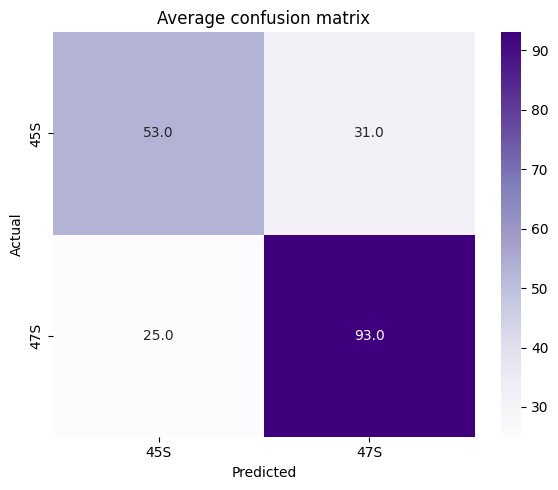

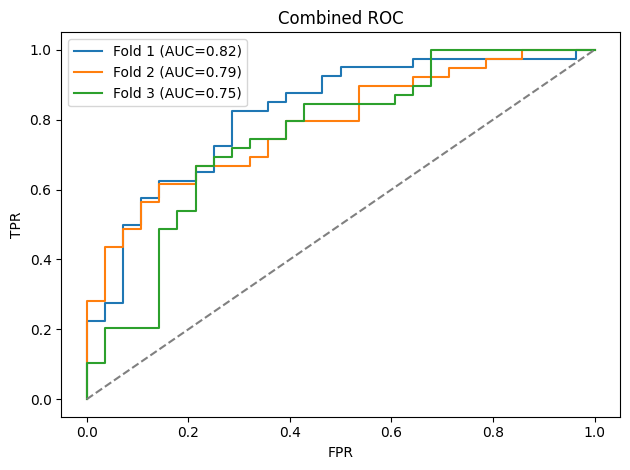

In [57]:
class_names = ["45S", "47S"]
model_key = "dense"

fold_hist_esm2_15, cls_esm2_15 = run_cv(model_key, X_esm2, y_esm2, class_names, verbose=True, random_state=0, dense_reps=10, n_splits=3)
plot_agg_metrics(fold_hist_esm2_15, class_names)

**Final training for amino acid sequence based model**

  rep 1/10: acc=0.824  auc=0.850
  rep 2/10: acc=0.809  auc=0.845
  rep 3/10: acc=0.824  auc=0.846
  rep 4/10: acc=0.809  auc=0.847
  rep 5/10: acc=0.838  auc=0.854
  rep 6/10: acc=0.824  auc=0.853
  rep 7/10: acc=0.809  auc=0.848
  rep 8/10: acc=0.824  auc=0.852
  rep 9/10: acc=0.824  auc=0.860
  rep 10/10: acc=0.809  auc=0.857
Fold 1: acc=0.838  auc=0.854
  rep 1/10: acc=0.672  auc=0.727
  rep 2/10: acc=0.716  auc=0.726
  rep 3/10: acc=0.701  auc=0.726
  rep 4/10: acc=0.701  auc=0.725
  rep 5/10: acc=0.672  auc=0.729
  rep 6/10: acc=0.716  auc=0.723
  rep 7/10: acc=0.701  auc=0.726
  rep 8/10: acc=0.716  auc=0.725
  rep 9/10: acc=0.701  auc=0.722
  rep 10/10: acc=0.701  auc=0.723
Fold 2: acc=0.716  auc=0.726
  rep 1/10: acc=0.731  auc=0.798
  rep 2/10: acc=0.746  auc=0.799
  rep 3/10: acc=0.731  auc=0.798
  rep 4/10: acc=0.746  auc=0.796
  rep 5/10: acc=0.731  auc=0.807
  rep 6/10: acc=0.731  auc=0.793
  rep 7/10: acc=0.731  auc=0.792
  rep 8/10: acc=0.746  auc=0.794
  rep 9/10: acc=

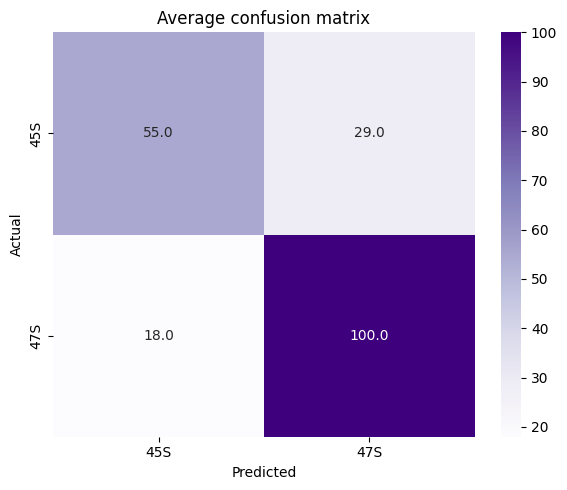

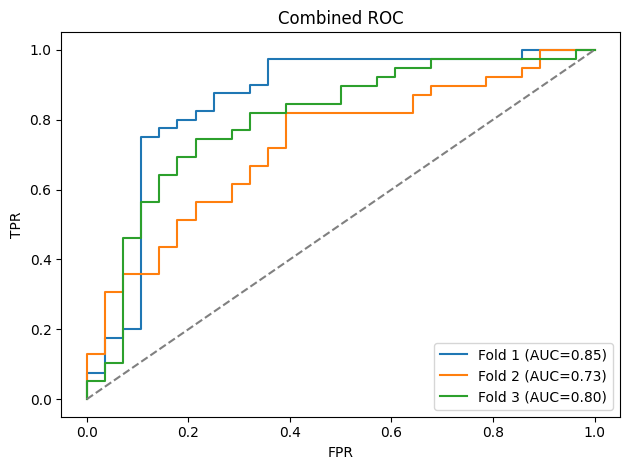

In [108]:
class_names = ["45S", "47S"]
model_key = "cnnlstm"

fold_hist_seqs, cls_seqs = run_cv(model_key, X_seqs, y_seqs, class_names, verbose=True, random_state=0, dense_reps=10)

plot_agg_metrics(fold_hist_seqs, class_names)

**Final performance analysis**

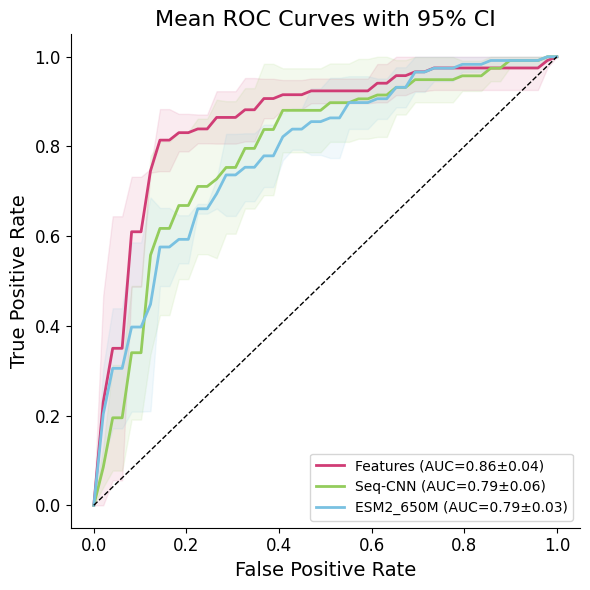

In [109]:
def plot_multi_cv_roc(fold_groups,
                      labels=None,
                      n_points=100,
                      ci_z=1.96,
                      figsize=(6,6)):

    n_models = len(fold_groups)
    if labels is None:
        labels = [f"Model {i+1}" for i in range(n_models)]
    if len(labels) != n_models:
        raise ValueError("`labels` must match number of fold_groups")

    mean_fpr = np.linspace(0, 1, n_points)
    plt.figure(figsize=figsize)

    for group, label in zip(fold_groups, labels):
        tprs = []
        aucs = []
        for h in group:
            fpr, tpr, auc_score = h["fpr"], h["tpr"], h["auc"]
            interp_tpr = np.interp(mean_fpr, fpr, tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(auc_score)
        tprs = np.vstack(tprs)
        aucs = np.array(aucs)

        mean_tpr = tprs.mean(axis=0)
        sem_tpr  = tprs.std(axis=0, ddof=1) / np.sqrt(tprs.shape[0])

        lower = np.clip(mean_tpr - ci_z * sem_tpr, 0, 1)
        upper = np.clip(mean_tpr + ci_z * sem_tpr, 0, 1)

        mean_auc = aucs.mean()
        std_auc  = aucs.std(ddof=1)
        hex_color_dict = {
            "Features": "#D03C75",
            "Seq-CNN": "#93CC5C",
            "ESM2_650M": "#79C1E1",
            "ESM2_3B": "#F9AA64",
            "ESM2_15B": "#F04020",
        }

        color = hex_color_dict.get(label, "#000000") 

        plt.plot(mean_fpr, mean_tpr,
                lw=2.0,
                color=color,
                label=f"{label} (AUC={mean_auc:.2f}±{std_auc:.2f})")

        plt.fill_between(mean_fpr, lower, upper, alpha=0.1, color=color)

    plt.plot([0, 1], [0, 1], "--", color="black", lw=1)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel("False Positive Rate", fontsize=14)
    plt.ylabel("True Positive Rate", fontsize=14)
    plt.title("Mean ROC Curves with 95% CI", fontsize=16)
    plt.legend(loc="lower right")
    plt.tight_layout()
    sns.despine()
    plt.show()

plot_multi_cv_roc(
    [fold_hist_cider, fold_hist_seqs, fold_hist_esm2_15],
    labels=["Features", "Seq-CNN", "ESM2_650M"],
    n_points=50
)